# Introduction

This notebook is one of several that I plan to make doing some data exploration of the NYC Tree Census data taken in 2015. The data can be found at the NYC OpenData website at https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh. The current version of the data is slightly different than the version that I downloaded, but overall is quite similar.

In this notebook, I develop a measure of the tree species diversity in NYC neighborhoods and do some basic data analysis. The data comes in a csv format, and I use pandas, numpy, matplotlib, and sklearn. I also pull in data on NYC Neighborhood Tabulation Areas for plotting. To help with this task, I have also created a small python package including some code to help out plotting NYC geospatial data.

Some techniques I use here include:
- Data reduction
- Feature engineering
- Outlier detection
- Linear regression
- Data visualization
- k-Fold cross validation
- Validation curves

### First things

First, I want to set up a couple basic things in the environment.

I'll import the basic packages I need (pandas, numpy, and matplotlib).

I will also set up the notebook so that matplotlib plots will show up.

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


### Reading the data

First, I'll read in the data. There is a "tree_id" feature in the data, but I'll leave a basic numeric index here. I also create a new feature for the tree genus using the Latin name of each species. This is easily done by combining the string split() function with a list comprehension. I am not using this right now, but in the case of smaller dataset or a dataset using a large number of species from a small number of genera, this would be a very useful feature.

There are also a number of redundant features. The Neighborhood Tabulation Area (NTA) is saved twice, as a code and as a string. Furthermore, the borough, state, and more can also be determined just from the NTA code. Here, I will save the borough and NTA information into a single separate frame for use later.

In [159]:
trees = pd.read_csv("data/street_trees_2015.csv")

trees['genus'] = [ str(x).split()[0] for x in trees.spc_latin ]

neighborhoods = trees.drop_duplicates(['nta'],keep='first')
neighborhoods = neighborhoods[['borocode','boroname','nta','nta_name']]

Now, let's see what is held in this tree.

In [160]:
trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 42 columns):
tree_id       683788 non-null int64
block_id      683788 non-null int64
created_at    683788 non-null object
tree_dbh      683788 non-null int64
stump_diam    683788 non-null int64
curb_loc      683788 non-null object
status        683788 non-null object
health        652172 non-null object
spc_latin     652169 non-null object
spc_common    652169 non-null object
steward       652173 non-null object
guards        652172 non-null object
sidewalk      652172 non-null object
user_type     683788 non-null object
problems      652124 non-null object
root_stone    683788 non-null object
root_grate    683788 non-null object
root_other    683788 non-null object
trunk_wire    683788 non-null object
trnk_light    683788 non-null object
trnk_other    683788 non-null object
brch_light    683788 non-null object
brch_shoe     683788 non-null object
brch_other    683788 non-null object
addre

### Memory Reduction

The tree takes up 220 MB of memory. This is well within what modern computers can save in memory, but it might be nice to reduce the memory footprint. There are a few ways that we can do this.

First, if we want to look at trees in New York, we might want to first focus on trees that are alive. This information is held within the "status" feature.

Second, there are also a number of features that we won't care about here. Things like the state legislative districts, the (x,y) coordinates in some special statewide coordinate system, the community board, the date at which the tree was recorded, and others are not going to be very useful to us at this point, so we can get rid of them. Others, such as "problems" are actually redundant given the other features. In the case of "problems," a one hot encoding of the possible values is already basically provided to us.

Also note the large number of "object" features. Most of these are just holding strings, and many only have a few possible options that are used. We can convert these to categorical variables to save space. An alternative would be to map to integer values and then convert to a small integer type such as np.int8 to reduce memory usage.

In [161]:
trees = trees[trees.status=='Alive']
to_drop = ['stump_diam','st_assem','st_senate','zip_city','created_at',
           'address','state','cncldist','nta_name','boroname','status',
           'x_sp','y_sp','problems','spc_latin','user_type']
trees = trees.drop(to_drop,axis=1)
trees['health'] = trees['health'].astype('category',categories=['Good','Fair','Poor'])
binary_feat = ['root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other']

#trees.sidewalk.

for feat in binary_feat:
    trees[feat] = trees[feat].astype('category',categories=['No','Yes'])
    
trees['sidewalk'] = trees['sidewalk'].astype('category',categories=['NoDamage','Damage'])
trees['curb_loc'] = trees['curb_loc'].astype('category',categories=['OnCurb','OffsetFromCurb'])
trees['guards'] = trees['guards'].astype('category',categories=['None','Helpful','Harmful','Unsure'])
trees['steward'] = trees['steward'].astype('category',categories=['None','1or2','3or4','4orMore'])

trees.info()
#trees.zip_city.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652173 entries, 0 to 683787
Data columns (total 26 columns):
tree_id       652173 non-null int64
block_id      652173 non-null int64
tree_dbh      652173 non-null int64
curb_loc      652173 non-null category
health        652172 non-null category
spc_common    652168 non-null object
steward       652173 non-null category
guards        652172 non-null category
sidewalk      652172 non-null category
root_stone    652173 non-null category
root_grate    652173 non-null category
root_other    652173 non-null category
trunk_wire    652173 non-null category
trnk_light    652173 non-null category
trnk_other    652173 non-null category
brch_light    652173 non-null category
brch_shoe     652173 non-null category
brch_other    652173 non-null category
zipcode       652173 non-null int64
cb_num        652173 non-null int64
borocode      652173 non-null int64
nta           652173 non-null object
boro_ct       652173 non-null int64
latitude      652

So, we have reduced the memory footprint of this by around a factor of 3. We could definitely reduce this even more
by changing the last few "object" features to categories or to integer types. int64 and float64 are also probably excessive given the information held here, but since the memory usage is already small compared to the memory on my laptop, I'm not going to try to push the memory usage down to the bare minimum possible.

### Neighborhood Data

I can use the DataFrame.groupby() function to organize the data by different fields. What I'm most interested in this particular notebook is now to compare neighborhoods, so I will definitely want to group things by NTA. I also group things by species, but I'll use that in a different notebook.

Here, I want to look at the diversity of trees in each neighborhood, so once I group by the neighborhood, I want to then select the species name. There are hundreds of thousands of total entries in the dataset but fewer than 200 species, so there should be a decent number of trees for nearly every species. For diversity, what should matter the most is the count of each species within each neighborhood. For this, I can use the Series.value_counts() function.

NTA is not the only spatial data that I can use. The census tract and borough are also included in the data, so I could make comparisons across regions that are more finely spaced (census tracts) or more coarsely spaced (borough). City block is probably going to be too small, and things like state legislative district and community board are not going to be too much different in scale than the 3 scales that I have already mentioned.

In [162]:
spc_counts = trees.groupby('nta')['spc_common'].value_counts()
nta_counts = trees.groupby('spc_common')['nta'].value_counts()

### Defining Diversity

There are many ways that we might be able to define diversity. A basic diversity measure should probably at least satisfy the following conditions:

 1) A tree that does not appear does not contribute to the diversity (i.e. contributes a value of 0 to the total)
 
 2) A tree that comprises 100% of a neighborhoods trees should also not contribute to the diversity (contributes 0)
 
Luckily, in physics we already have a very common statistic for this sort of thing: entropy. Entropy is basically a measure of how random things are. A maximally diverse neighborhood would be one where the trees are chosen completely randomly from the set of possible species, while a minimally diverse one would only contain a single species.

I will define the "tree diversity" to be a tree "entropy." Mathematically, I define the diversity of neighborhood $j$ to be:

\begin{equation}
S_j = - \sum\limits_{i} \frac{N_{ij}}{T_j} \log \frac{N_{ij}}{T_j}
\end{equation}

Here, $N_{ij}$ is the number of trees of species $i$ in neighborhood $j$. $T_j = \sum\limits_{i} N_{ij}$ is the total number of recorded street trees in neighborhood $j$. The sum is over all possible tree species.

Now, let's consider how this statistic works. Because $N_{ij}\in \mathcal{N}\cup {0}$, $\le N_{ij}/T_{j} \le 1$ by construction. If we let
$$ f(y) = -y\log y$$
then
$$ f'(y) = - (1 + \log y) $$
and
$$ f''(y) = -\frac{1}{y} $$.

Using these equations, we see that: $f(0) = f(1) = 0$, satisfying our two conditions spelled out above.
We can also see that $f'(1/e) = 0$ and $f(1/e) = 1/e$. Furthermore, $f''(y)<0 \forall y\in(0,1]$. These facts mean that $f(y) \ge 0 \forall y\in[0,1]$ and that $f(y)$ is a concave function over the range of $y$ that we care about.

I won't try to prove it here, but by using this definition of $S_j$, we get a measure of the diversity that is maximal when  $N_{ij} = N_{kj} \forall i,k$. I'm sure there are other measures that might be useful but this one might be best because it is well-known from physical science and also because similar statistics appear often in data science/optimization problems (see the cross-entropy loss used in many classification problems).

In [163]:
# Get the entropy/diversity from a pandas Series
def get_entropy(x):
    total = int(x.sum())
    count = len(x)
    if total == 0:
        return 0
    S = -(x/total * np.log(x/total) ).sum()
    return S,total,count

# Loop over groups from the results of a DataFrame.groupby() to get the diversity of each group.
# Save this as a DataFrame
def make_entropy_df(counts,idx_name,type_name):
    idxs = counts.index.get_level_values(0).unique()
    entropy = np.zeros(len(idxs))
    total = np.zeros(len(idxs))
    ntypes = np.zeros(len(idxs))
    for i,idx in enumerate(idxs):
        entropy[i],total[i],ntypes[i] = get_entropy(counts[idx])
    entropy_df = pd.DataFrame({'entropy':entropy,'count':total,'n_'+type_name:ntypes},index=idxs)
    entropy_df.index = entropy_df.index.rename(idx_name)
    return entropy_df

Now that I've defined some functions to calculate the diversity, I can apply these to my data.

I will also use a left inner join with my neighborhood info DataFrame to get some human-readable values for things like the NTA. My new DataFrame will be indexed by NTA code and then contain:
- Total tree count
- Tree diversity (entropy)
- Number of species present in NTA
- Borough numeric code
- Borough name
- NTA name

In [164]:
nta_entropy = make_entropy_df(spc_counts,'nta','species')
spc_entropy = make_entropy_df(nta_counts,'species','nta')
nta_entropy = nta_entropy.merge(neighborhoods,how='left',left_index=True,
                                right_on='nta',copy=False).set_index(nta_entropy.index)
nta_entropy = nta_entropy.drop(['nta'],axis=1)
nta_entropy.head()

,count,entropy,n_species,borocode,boroname,nta_name
nta,,,,,,
BK09,1718.0,2.734650,70.0,3,Brooklyn,Brooklyn Heights-Cobble Hill
BK17,4957.0,2.933100,92.0,3,Brooklyn,Sheepshead Bay-Gerritsen Beach-Manhattan Beach
BK19,1173.0,3.231750,72.0,3,Brooklyn,Brighton Beach
BK21,1317.0,3.072560,58.0,3,Brooklyn,Seagate-Coney Island
BK23,455.0,2.476099,27.0,3,Brooklyn,West Brighton


### Analyzing the Tree Diversity

Now, I have a dataframe with the street tree diversity of each NYC neighborhood (excluding a small number of NTAs that seem to be parks with no regular streets to include in the census).

First, we should look at the most and least diverse neighborhoods.

In [165]:
print(nta_entropy.sort_values(by='entropy')[['count','entropy','n_species','nta_name']].head())
print(nta_entropy.sort_values(by='entropy')[['count','entropy','n_species','nta_name']].tail())

       count   entropy  n_species                        nta_name
nta                                                              
MN50   438.0  1.385913       21.0  Stuyvesant Town-Cooper Village
BK93   671.0  2.228374       23.0                   Starrett City
MN17  1120.0  2.320368       37.0           Midtown-Midtown South
MN31  2215.0  2.329904       55.0     Lenox Hill-Roosevelt Island
MN15  1884.0  2.364305       52.0                         Clinton
       count   entropy  n_species                                 nta_name
nta                                                                       
BK82  9188.0  3.555708      117.0                            East New York
BX37  3008.0  3.578057       91.0  Van Nest-Morris Park-Westchester Square
BX59  2709.0  3.591287       93.0                    Westchester-Unionport
SI28  2987.0  3.604598       97.0                            Port Richmond
QN52  3081.0  3.637465      105.0                            East Flushing


We see that Stuyvesant Town-Cooper village has by far the least-diverse set of street trees. It also seems to have a fairly small number of trees. There is also maybe a decent gap betewen Starrett City and the rest, but it is less clear if this is really an outlier. East Flushing has the most diverse set of trees but there isn't much of a gap between the different neighborhoods with high diversity.

There are some interesting things here, though.
Stuy Town, Peter Cooper Village, and Starrett City are all planned neighborhoods meant as affordable housing. Within the neighborhoods, there are many identical buildings, so it's not surprising that there may be only a few highly-favored tree species.

Midtown is the busiest business district, and Lenox Hill is one of the most densely populated neighborhoods in the US, so it's not surprising that they have low tree diversity; Many trees simply won't be able to thrive in such an environment. Clinton (aka Hell's Kitchen to most people) is just west of Times Square. The most diverse neighborhoods are all quite far from skyscraper and highrise districts of Manhattan.

One interesting thing that I notice is that according to the tree census, East New York is one of the most diverse neighborhoods, while Starrett City is one of the least. These neighborhoods are adjacent, so it's interesting to see the contrast. Furthermore, East New York, in Brooklyn near JFK airport, is probably one of the poorest neighborhoods in the city. I would have expected to see low tree diversity in poorer areas, but this shows that this may not be the case. I will likely compare the socioeconomic status of different areas to the tree census data in another notebook, so maybe we will find that rather than diversity, there are certain tree species that are most likely to occur in wealthy or poor neighborhoods. That kind of information might be useful for both real estate companies and for urban planning, since it might give some hints as to what kinds of urban environments are preferred by residents.

### Plotting the Data

One thing that we might worry about with this dataset is that maybe neighborhoods with few total trees tend to have much lower diversity. If this is the case, then our diversity measure will just be highly correlated with tree number, which won't be very useful. At some level, this must be true, as a neighborhood with a single tree will have a diversity score of 0. We can get a rough sense of this by looking at a scatter plot.

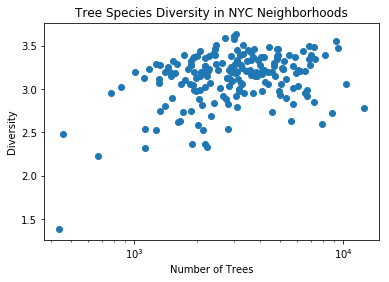

In [166]:
plt.scatter(nta_entropy['count'],nta_entropy.entropy)
plt.xscale('log')
plt.xlabel('Number of Trees')
plt.ylabel('Diversity')
plt.title('Tree Species Diversity in NYC Neighborhoods')
plt.show()

By eye, we can see that if there is a correlation, it will be small compared to the spread in diversity. So, our diversity measure does seem to be measuring something different from what is already in the data. Maybe there is a slight positive correlation.

But, it will be good to quantify this. First, let's look at a histogram of the diversity scores.

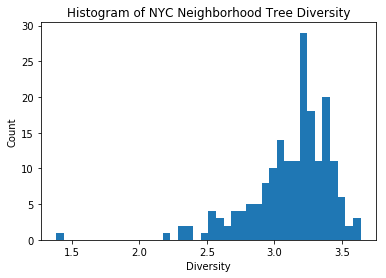

In [167]:
plt.hist(nta_entropy['entropy'],bins=40)
plt.xlabel(r'Diversity')
plt.ylabel('Count')
plt.title('Histogram of NYC Neighborhood Tree Diversity')
plt.show()

The histogram definitely does not show something simple like a Gaussian distribution, but it isn't so different either. There do appear to be some values that appear much more than others, so it's not totally smooth, but one can imagine that a somewhat skewed Gaussian like a flipped lognormal distribution might be a decent model for the distribution. There is at least one outlier (Stuy Town) that should be removed before we do any numerical analysis, since that point might have a large effect on anything like a basic regression model.

While it would be easy to find that point just from this plot, I will instead do something a bit more complicated to identify it as an outlier.

### Anomaly Detection

Because the data points lie mostly in a blob in the 2D space of # of trees and diversity score, I can approximate the distribution with a 2D Gaussian distribution (i.e. a multivariate Gaussian). Gaussians are convenient because I can then use the means for each feature and the covariance matrix to calculate the probability density at any given point in my feature space.

Here, I define a function to do just that, creating a new feature giving the probability density for each point given this multivariate Gaussian model. Because the tree count covers several orders of magnitude, the logarithm will be more useful here.

In [168]:
nta_entropy['LogCount'] = np.log10(nta_entropy['count'])
cov = nta_entropy[['LogCount','entropy']].cov()
print('Count/Entropy covariance')
print(cov)

mean = nta_entropy[['LogCount','entropy']].mean()

def calc_prob(X,mean,cov):
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)    
    A = 1./(2*np.pi * np.sqrt( np.abs(det_cov)))
    expo = np.exp(-0.5 * (X-mean).T.dot(inv_cov.dot(X-mean)))
    return A * expo

nta_entropy['Prob'] = [calc_prob(np.array([x,y]),mean,cov) for x,y in zip(nta_entropy['LogCount'],nta_entropy['entropy'])]

Count/Entropy covariance
          LogCount   entropy
LogCount  0.063297  0.026559
entropy   0.026559  0.093097


Since this is a two-dimensional analysis here, it is easy to make some plots of the results. On the left, I have a scatter plot. On the right, I have plots of the logarithm of the probability density, one with all points, and one with the Stuy Town point removed. We see that Stuy Town is separated by orders of magnitude from the other points, while the remainder are only separated by small amounts.

I'm just going to manually ID one point as an outlier, but there are several ways that we can automatically remove outliers, including:
- Set a threshold where everything below some minimum value of the ratio of the probability to the max value in the dataset is removed.
- Set some maximum gap where if we find a gap in log probability larger than some threshold, we remove all points with worse probability than the point before the gap
- Calculate the thresholds above using the data (maybe calculate quantiles and set to x times some range)
- Remove the worst number or percentage of points

For some of these, we might want to iterate by removing some points, recalculating the probabilities and continuing until we stop removing any points. In general, though, it would be best to find some method that does not require us to look at the data before making decisions. Doing everything as blindly as possible can help avoid biasing results. We'll still want to see what is being removed since a blind analysis can easily go wrong, and it's better to do a non-blind analysis than have a blind analysis fail to do anything useful.

For now, I will just remove the single worst point when I want to do some quantitative analysis of the data.

In [169]:
print('Outlier: ' + nta_entropy.loc[nta_entropy.Prob.argmin(),'nta_name'])

Outlier: Stuyvesant Town-Cooper Village


As we saw before, Stuyvesant Town-Cooper Village has the worst diversity score by far. Before getting rid of it, we can look at why it has the worst score so we can understand why it is an outlier.

In [170]:
stuy_town = trees[trees.nta==nta_entropy.Prob.argmin()]
gb = stuy_town.groupby(by='spc_common')['spc_common'].count().sort_values(ascending=False)
print(gb)

spc_common
honeylocust            279
London planetree        81
Sophora                 11
Japanese zelkova        11
ginkgo                   6
pin oak                  6
swamp white oak          5
American linden          5
Callery pear             5
littleleaf linden        5
common hackberry         5
Kentucky coffeetree      4
white oak                3
northern red oak         3
American elm             3
tree of heaven           1
green ash                1
sawtooth oak             1
Amur maple               1
Amur maackia             1
shingle oak              1
Name: spc_common, dtype: int64


We see that actually a majority of street trees in this neighborhood are from a single species: the honeylocust. About half the remainder are from a single other species too, so more than 80% of trees are from just two species. Obviously, the small number of trees is not the main problem.

### Mapping the Data

As I mentioned at the beginning, the NYC OpenData page provides maps of various kinds of subdivisions of New York City. Since the NTA codes and names are readily available and each neighborhood has hundreds of trees, the NTA is a good unit to use.

To help with this, I have created some code to have a simple API for making these plots. These are held in my NYCDataTools repository, although the data should be downloaded from the website to be sure that the repository avoids any copyright issues.

In [171]:
from nyc.mapping import NeighborhoodMapper
from nyc.plotting import MapPlotter



Once I have the shapefiles and some related files downloaded, it only takes a handful of lines to create the plot. My code requires several other packages, including matplotlib, numpy, descartes, shapely, fiona, pyproj, and pandas. Even if the NTA info were not already included, my code allows for mapping latitude and longitude to NTA.

#### Diversity Score Map

I will first plot the diversity score for each neighborhood.

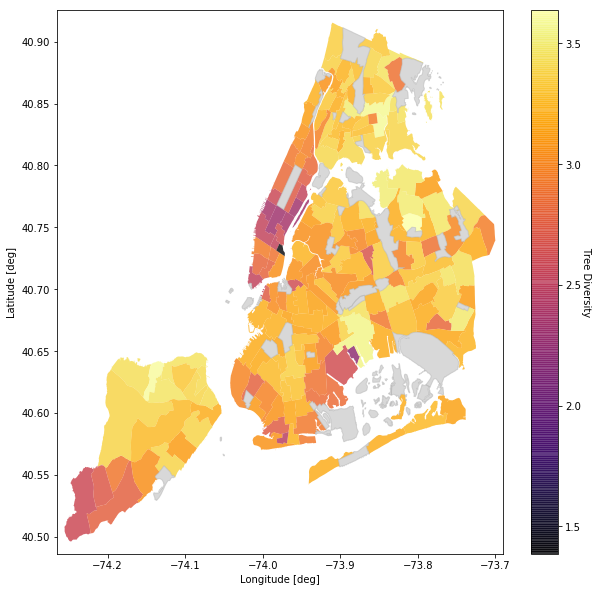

In [172]:
nm = NeighborhoodMapper(path='data/neighborhoods.shp')
mp = MapPlotter(nm)

fig = plt.figure(1,figsize=[10,10])
ax = fig.add_subplot(111)

mp.plot(nta_entropy['entropy'],ax=ax)
mp.cbar.set_label('Tree Diversity',rotation=270,labelpad=10)
plt.show()

We see that street tree diversity is generally lower in Manhattan (especially below 125th St) than in the other boroughs. There is also fairly low diversity in some parts of Brooklyn far from Manhattan and also in the southern tip of Staten Island. The latter point I found surprising, since this is one of the least urban parts of the city.

We can also see in grey the areas with no tree data. These are mostly things like large parks and the airports.

#### Street Tree Count by Neighborhood

Here, I plot the count of street trees in each NTA. There are huge numbers of trees in southern Staten Island, which makes it somewhat puzzling why the diversity is so small. I am not too familiar with this area, but perhaps it includes many large planned neighborhoods with identical trees. It seems odd that a mostly suburban area would have a tree diversity score as low as parts of lower Manhattan.

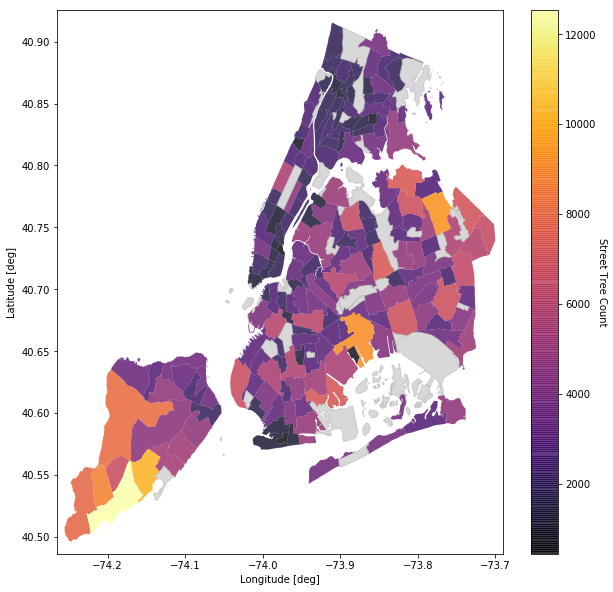

In [173]:
fig = plt.figure(1,figsize=[10,10])
ax = fig.add_subplot(111)

mp.plot(nta_entropy['count'],ax=ax,area_norm=False)
mp.cbar.set_label('Street Tree Count',rotation=270,labelpad=10)
plt.show()

#### Street Tree Density

We can also see what the street tree density is for each neighborhood. My plotting tools allow for using the shape area from the shapefiles to get an area-normalized plot.

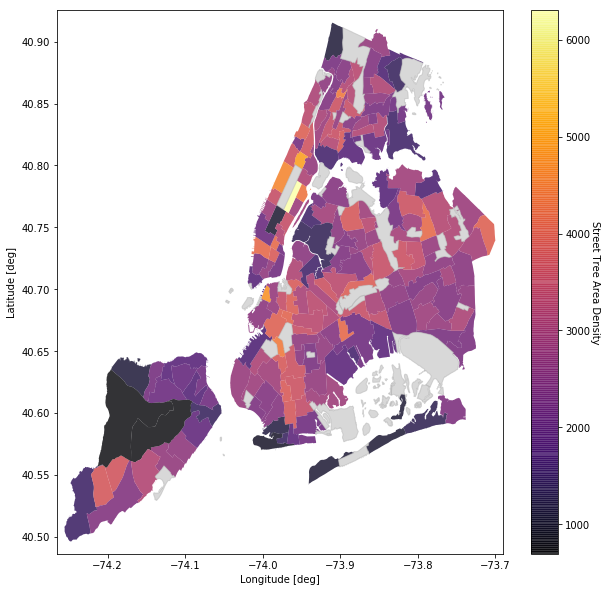

In [174]:
fig = plt.figure(1,figsize=[10,10])
ax = fig.add_subplot(111)

mp.plot(nta_entropy['count'],ax=ax,area_norm=True)
mp.cbar.set_label('Street Tree Area Density',rotation=270,labelpad=10)
plt.show()

This is also interesting. It looks like central Staten Island is one of the lowest-density areas while the Upper East Side is the highest. One might not expect that, but there may be a simple explanation. This dataset is looking at street trees. The street density is higher in a high-population-density area, so there may be a higher density of street trees due to the higher density of streets.

Basically, area density is not really the proper normalization factor here. We really want the street length density, which will be a better measure of how much space is available to place trees. Unfortunately, I don't have that data, so this is the best I can do. I'm sure that data exists, but I can also imagine some complicated and computing-power-intensive ways to try to automate that process. (For example, one could imagine training a convolutional neural net to identify streets in an image. Of course, Google already has the streets mapped out in Google maps, so maybe we can figure out how to download that and then count the number of street points within each NTA).

### Linear Regression: How Much Does Diversity Depend on Total Tree Count

We can already see that there is at best a weak correlation between tree count and tree diversity score. Can we try to quantify this?

First, we should drop the outlier.

In [175]:
nta_no_out = nta_entropy.drop([nta_entropy.Prob.argmin()],axis=0)
nta_no_out.shape

(187, 8)

Now, let's quickly check the new covariance. Again, I'll be using the logarithm of the tree count to get more meaningful values here. Otherwise, the variance of the count overwhelms everything.

In [176]:
cov = nta_no_out[['LogCount','entropy']].cov()
cov

,LogCount,entropy
LogCount,0.059915,0.018904
entropy,0.018904,0.077261


Compared to before, we see a significant reduction in the covariance term, as well as a large reduction in the variance of "entropy" (diversity score). We can now calculate the principal axes by getting the eigenvectors and eigenvalues of the distribution. This is closely related to PCA, although in this case, we have not tried to normalize my variables.

In PCA, we would first normalize each feature to 0 mean and an variance of 1. We can then use the eigenvector corresponding to the largest eigenvalue (absolute value) to reduce to a single variable with the largest possible variance. There are many tools to do just this, so I won't bother showing this here.

In [177]:
cov = cov.as_matrix()

w,v = np.linalg.eig(cov)

In [178]:
print('Eigenvalues: ')
print(w)
print('Eigenvectors [columns]:')
print(v)

Eigenvalues: 
[ 0.04779002  0.08938673]
Eigenvectors [columns]:
[[-0.84172576 -0.53990531]
 [ 0.53990531 -0.84172576]]


In [179]:

180./np.pi * np.arctan2(v[1,1],v[0,1]) % 180

57.322806761458196

So, again using a multivariate Gaussian model, the longest principal axis lies at an angle of 57.3$^\circ$ in the space of [log10(tree count), diversity score]

#### Linear Regression

The data is clearly not really drawn from a multivariate Gaussian, so we should also look at this in another way. Here, I will use scikit-learn's LinearRegression class to fit a line to the data.

In [180]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
lr = LinearRegression()
lr.fit(nta_no_out[['LogCount']],nta_no_out[['entropy']])
print('Slope: '  + str(lr.coef_[0][0]))
print('Angle: ' + str(180./np.pi * np.arctan2(lr.coef_[0][0],1)))
print('Intercept: ' + str(lr.intercept_[0]))
# The score() function of LinearRegression is actually also the R2 score
# but I'll just do it this way instead
print('R2: ' + str(r2_score(nta_no_out[['entropy']],lr.predict(nta_no_out[['LogCount']]) )))

Slope: 0.315506971088
Angle: 17.5108487403
Intercept: 2.03709206884
R2: 0.0771957997418


#### Discussion of Fit Results

Here, we see that we get quite different results compared to the principal axis analysis. The angle of the best fit line is 40$^\deg$ offset in angle compared to the largest axis.
We also see the the R$^2$ score is quite small: only 0.077. Evidently, tree count explains less than 10% of the variance in diversity. This is actually good for us, as it bolsters our case that the diversity score has added something that is not included in something like tree count. We could also check the species count as well to see if there is any correlation there.

For now, let's plot our best fit line on top of our data.

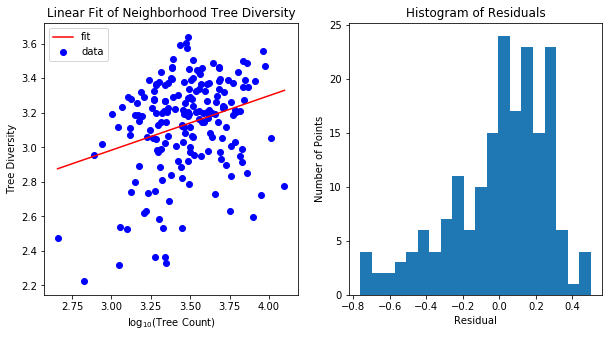

In [181]:
def plot_1d_regression(x,y,linreg,xlabel,ylabel,title,has_int=True):
    idxs = np.argsort(x)
    x = x[idxs]
    y = y[idxs]
    yfit = np.zeros(x.shape[0])
    for idx,xval in enumerate(x):
        xtmp = 1
        if has_int==True:
            yfit[idx] = linreg.intercept_[0]
            xtmp = xval
        coeffs = linreg.coef_
        if type(coeffs[0])==np.ndarray:
            coeffs = coeffs[0]
        for coef in coeffs:
            yfit[idx] += coef * xtmp
            xtmp *= xval
    fig = plt.figure(1,figsize=(10,5))
    ax = fig.add_subplot(121)
    ax.scatter(x,y,label='data',c='b')
    ax.plot(x,yfit,label='fit',c='r')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax = fig.add_subplot(122)
    ax.hist(y-yfit,bins=20)
    ax.set_xlabel('Residual')
    ax.set_ylabel('Number of Points')
    ax.set_title('Histogram of Residuals')
    plt.show()
    
plot_1d_regression(nta_no_out['LogCount'],nta_no_out['entropy'],lr,
                   r'log$_{10}$(Tree Count)',
                   'Tree Diversity',
                   'Linear Fit of Neighborhood Tree Diversity'
                  )

We can see that because the data is so blob-like, using a higher order histogram is unlikely to improve our model much.

We also see something interesting in the residual histogram (and also in the scatter plot). The distribution shows a main blob with a significant low-diversity tail. In most basic regression problems, this potentially gives us a problem because the method typically assumes that points are drawn from a Gaussian distribution with a fixed width. The residuals here are clearly non-Gaussian, and the distribution is such that the residuals will never be Gaussian. In this case, it seems that there's not much to learn from a fit and the small number of data points makes it hard to do much else. In general, it might be advantageous to try to transform the diversity score to make this distribution more Gaussian so that we don't break any of the assumptions of the regression method too much.

In a different notebook, I look at the diversity of neighborhoods for different tree species, where a fit is much more effective.

### Would A Higher Order Polynomial Help?

There is a fairly straightforward way to see if a higher-order polynomial would help the fit. We can make a validation curve.

The small number of points and the fact that some of the low-count, low-diversity points could maybe be labeled outliers might hurt any fit, but that is beyond the scope of this notebook.

I will do this in the following way:
 1) Add in higher-order terms of log10(tree count)
 2) Use 5-fold cross validation to split the data into 5 independent sets of 20% of the data each
 3) Run the fit 5 times on different sets of 80% of the data (test set)
 4) Get the $R^2$ score on each test set and for the 20% validation set for each test set
 5) Get the average and standard deviation of the 5 fits
 6) Do the cross validation for polynomials of different orders
 
There are existing tools to do much of this in scikit-learn, such as sklearn.model_selection.cross_val_score(), but I'll do most of it on my own except for using sklearn.model_selection.KFold to set up the cross validation. 

In [182]:
# First, create some new polynomial features:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
poly_feat = PolynomialFeatures(degree=10)
X = poly_feat.fit_transform(nta_no_out[['LogCount']])
y = nta_no_out['entropy']

# Our features now include a constant value
lr = LinearRegression(fit_intercept=False)

kf = KFold(n_splits=5,random_state=999,shuffle=True)
# I'll use the same sets for each of the models

r2_train = np.zeros([5,11])
r2_val = np.zeros([5,11])
# more on these next two later
r2_train_adj = np.zeros([5,11])
r2_val_adj = np.zeros([5,11])
fold = 0
for train_idx,val_idx in kf.split(X):
    X_train = X[train_idx,:]
    y_train = y[train_idx]
    X_val = X[val_idx,:]
    y_val = y[val_idx]
    n_tr = y_train.shape[0]
    n_val = y_val.shape[0]
    
    for i in range(11):
        lr.fit(X_train[:,:i+1],y_train)
        R2 = lr.score(X_train[:,:i+1],y_train)
        r2_train[fold,i] = R2
        r2_train_adj[fold,i] = R2 - (1-R2) * i/(n_tr-i-1)
        R2 = lr.score(X_val[:,:i+1],y_val)
        r2_val[fold,i] = R2
        r2_val_adj[fold,i] = R2 - (1-R2) * i/(n_val-i-1)
    fold += 1

Now that we've calculated the $R^2$ values, we can plot them. We'll do this twice, so we should define a function to reduce the amount of code to write.

In [183]:
def plot_validation_curve(r2_train,r2_val,ylabel=r'R$^2$ Score'):
    r2_tr_mean = np.mean(r2_train,axis=0)
    r2_tr_std = np.std(r2_train,axis=0)
    r2_val_mean = np.mean(r2_val,axis=0)
    r2_val_std = np.std(r2_val,axis=0)
    xvals = np.array([1.0*x for x in range(11)])
    plt.errorbar(xvals,r2_tr_mean,yerr=r2_tr_std,label='Test')
# Offset this by a bit to avoid blocking the first plot
    plt.errorbar(xvals+0.1,r2_val_mean,yerr=r2_val_std,label='Validation',c='r')

    plt.xlabel('Polynomial Order')
    plt.ylabel(ylabel)
    plt.title('Validation Curve')
    plt.ylim([0,0.4])
    plt.legend(loc='upper left')
    plt.show()

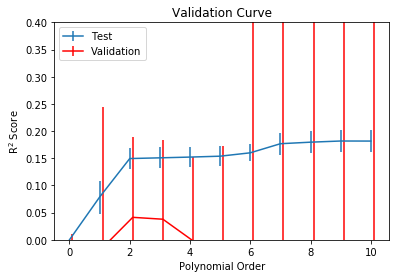

In [184]:
plot_validation_curve(r2_train,r2_val)

We see that on the test set, our $R^2$ values are pretty stable. The score rises basically by definition as we add more flexibility to the model.

For the validation set, we actually get negative values on average for $R^2$. However, you might recall that $R^2$ ranges from 0 to 1. So what is going on?

This means that on our validation set, we very often end up __increasing__ the variance of the data. Basically, our fits are often doing more harm than good if we try to generalize our model to new data. While it might describe the data we have, the regression is basically useless at making predictions. Again, this is actually good for us since it means that the two variables aren't really related to each other very much at all. 

The fact that the score always rises as we add more features always happens. Ignoring the fact that we can't make better predictions than just picking the average value of all data points, there is a way to deal with this. The adjusted $R^2$ score adds a penalty when we increase the number of features used in the fit.

Below I plot the adjusted $R^2$ score instead.

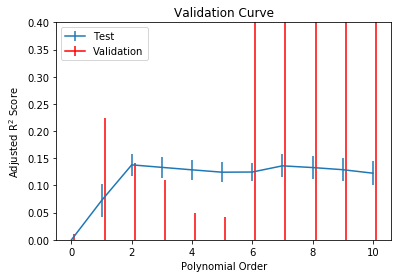

In [185]:
plot_validation_curve(r2_train_adj,r2_val_adj,ylabel=r'Adjusted R$^2$ Score')

Now, we can see that on the test set the score no longer rises as the polynomial order increases. In fact, we get the best results for a quadratic function.

We see that now the mean scores of all nontrivial polynomials are negative for the validation set, so the trivial model where we just predict the same value of diversity regardless of the number of trees will generalize the best.

Let's see what a quadratic fit looks like.

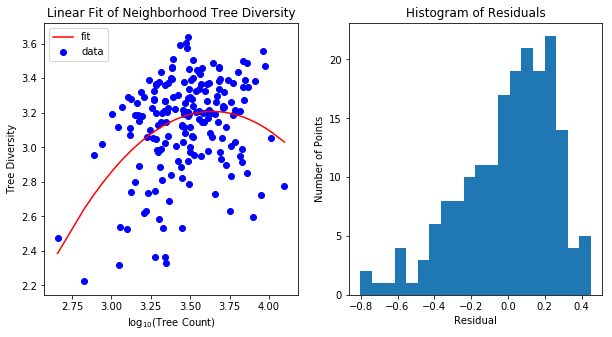

In [186]:

lr.fit(X[:,:3],y)
plot_1d_regression(X[:,1],y,lr,
                   r'log$_{10}$(Tree Count)',
                   'Tree Diversity',
                   'Linear Fit of Neighborhood Tree Diversity',
                   has_int=False
                  )

So, we see that we are clearly overfitting to the high leverage points around (2.75,2.4). Comparing this to the linear model, it's really not clear that this does a much better job. The adjusted $R^2$ value for the validation set goes from -0.043 for a linear model to -0.014 for a quadratic model. While maybe there is a marginal improvement in average performance, in both cases, the model does not generalize well at all, although these on average are not much worse than a trivial constant value model. The variance is also smaller for the quadratic model, so it may be preferable to the linear one if only to ensure better stability in results if any new data were added.

### Conclusions

That's it for this notebook. We've gone over a number of different techniques for analyzing this data, including things like visualization, feature engineering, and regression. We have developed a "tree diversity score" to use to compare the trees found in different neighborhoods.

Some other things that we can consider in other notebooks include:
- How spread out are different tree species in New York?
- Are trees related to neighborhood socioeconomic status? If so, in what ways?